In [ ]:
%matplotlib inline

#import gym
import matplotlib
import numpy as np
import itertools
from envs.Hospitalenv import Hostipal

import matplotlib.pyplot as plt
from envs import Plotting
from collections import defaultdict
import sys
import seaborn as sns
import timeit

matplotlib.style.use('ggplot')
import math

In [ ]:
lam=6 ## for generating request from possion distribution with Lambda = lam
beds=100

env=Hostipal(beds,lam)

In [ ]:
def mat(row,col,val):
    matrow=[]
    for i in range(row):
        matrow.append(val)
    mat=[]
    for j in range(col):
        mat.append(list(matrow))
    return mat


In [ ]:
Q_table=mat(env.m,env.m,0.5)
N_table=mat(env.m,env.m,1)
R_table=mat(env.m,env.m,0)


In [ ]:
def policy_MCTS(env,Q,N,s):
    max1=-100000000000
    a=None
    C=1.414
    
    
    for a in range(env.m-env.OccupiedBed):
        log_value=np.log(N[s][a])
        tar_value=log_value/sum(N[s])
        U=C*math.sqrt(tar_value)
        pi=U+Q[s][a]
        if pi>=max1:
            max1=pi
            action=a
    return action 
            
        

In [ ]:
def make_epsilon_greedy_policy(Q, epsilon, nA,env,N):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
       
        A = np.ones(env.m-env.OccupiedBed, dtype=float) * epsilon / (env.m-env.OccupiedBed)
        
        #print("OccupiedBed",env.OccupiedBed)
        
        #print("A",A)
        
        best_action = policy_MCTS(env,Q,N,observation)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn


In [ ]:
# def make_epsilon_greedy_policy1(Q, epsilon, nA,env):
#     """
#     Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
#     Args:
#         Q: A dictionary that maps from state -> action-values.
#             Each value is a numpy array of length nA (see below)
#         epsilon: The probability to select a random action . float between 0 and 1.
#         nA: Number of actions in the environment.
    
#     Returns:
#         A function that takes the observation as an argument and returns
#         the probabilities for each action in the form of a numpy array of length nA.
    
#     """
#     def policy_fn(observation):
       
#         A = np.ones(env.m-env.OccupiedBed, dtype=float) * epsilon / (env.m-env.OccupiedBed)
        
#         #print("OccupiedBed",env.OccupiedBed)
        
#         #print("A",A)
        
#         best_action = np.argmax(Q[observation])
#         A[best_action] += (1.0 - epsilon)
#         return A
#     return policy_fn


In [ ]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.1, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    global Q_table
    global N_table
    global R_table
    nA = env.m 
    Q=Q_table
    N=N_table
    R=R_table
    #print(nA)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
#Q = defaultdict(lambda: np.zeros(nA))
       

    #print(len(Q))
    # Keeps track of useful statistics
    stats = Plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, nA,env,N)
    
    for i_episode in range(num_episodes)  :
        
        epsilon /= (i_episode + 1)
        N=mat(env.m,env.m,1)
        
        # Print out which episode we're on, useful for debugging.
        if ((i_episode + 1) % 500 == 0):
            print("Episode {}/{}.".format(i_episode + 1, num_episodes),flush=True)
            sys.stdout.flush()
        
        #print("reset")
        state = env.reset()
        terminated = False
#         Q=MCTS(env,state)
        for t in itertools.count():

            #sys.stdout.write('\r'+str(t))
            
            request=max(1,env.request())
            #print("request",request)
            # sample the action from the epsilon greedy policy
            action = min(np.random.choice(env.m-env.OccupiedBed, p=policy(state)),request)
            #sys.stdout.write('actions --> \r'+ env.possibleaction[action])
            
            #print("action :",action)
            
            # Perform the action -> Get the reward and observe the next state
            #print("Before",env.getAgentRowAndColoumn(),"action",env.possibleaction[action])
            new_state, reward, terminated, old_state = env.step(action)

            
#             print("reward :",reward)
#             print("old state",old_state)
#             print("action",action)
#             print("new_state :",new_state)
#             print('-'*100)

            
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            # value that we should have got
            # The Q-learning target policy is a greedy one, hence the `max`
#             td_target = reward + discount_factor * max(Q[new_state])
#             td_error = td_target - Q[state][action]
            # Updating N
            N[state][action]+=1
            R[state][action]+=reward
            # Q-learning update
            Q[state][action] = (Q[state][action]+R[state][action]+max(Q[state]))/N[state][action]
            
            # update current state
            state = new_state
            
            if terminated:
                break
    return Q, stats

In [ ]:
Q, stats = q_learning(env, 100)

In [ ]:
dict_Q={}
for i , j in enumerate(Q):
    dict_Q[i]=np.array(j)
    
    

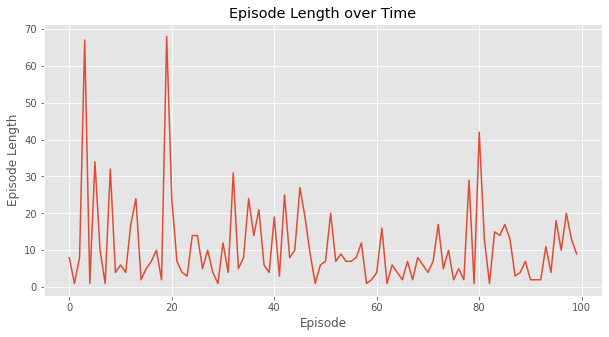

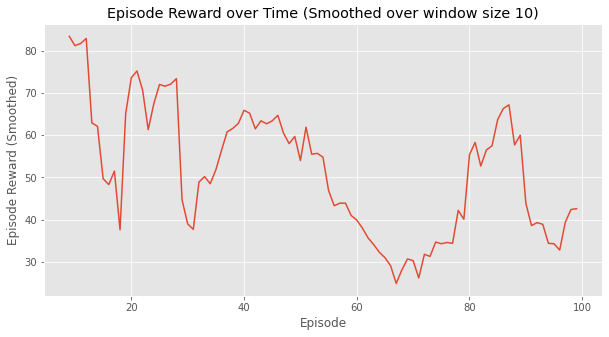

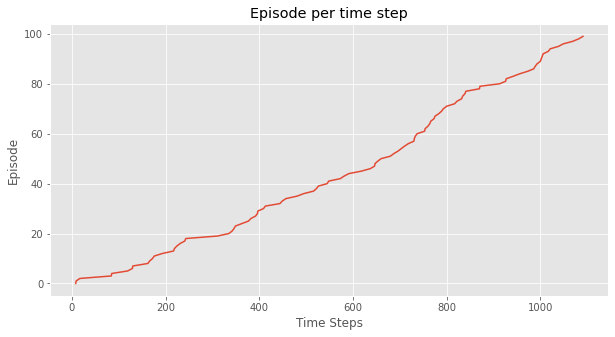

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [ ]:
Plotting.plot_episode_stats(stats)

In [ ]:
#Plotting.plot_episode_stats(stats1)

In [ ]:
stats


Stats(episode_lengths=array([ 8.,  1.,  8., 67.,  1., 34., 10.,  1., 32.,  4.,  6.,  4., 17.,
       24.,  2.,  5.,  7., 10.,  2., 68., 24.,  7.,  4.,  3., 14., 14.,
        5., 10.,  4.,  1., 12.,  4., 31.,  5.,  8., 24., 14., 21.,  6.,
        4., 19.,  3., 25.,  8., 10., 27., 19.,  9.,  1.,  6.,  7., 20.,
        7.,  9.,  7.,  7.,  8., 12.,  1.,  2.,  4., 16.,  1.,  6.,  4.,
        2.,  7.,  2.,  8.,  6.,  4.,  7., 17.,  5., 10.,  2.,  5.,  2.,
       29.,  1., 42., 13.,  1., 15., 14., 17., 13.,  3.,  4.,  7.,  2.,
        2.,  2., 11.,  4., 18., 10., 20., 13.,  9.]), episode_rewards=array([ 54.,  16.,  58., 307.,  18., 151.,  43.,  11., 153.,  23.,  32.,
        21.,  70., 107.,  10.,  27.,  29.,  43.,  14., 298., 117.,  37.,
        25.,  13.,  72.,  72.,  25.,  48.,  27.,  11.,  60.,  24., 137.,
        26.,  55., 105.,  71.,  92.,  35.,  23.,  91.,  17., 100.,  45.,
        48., 112.,  84.,  50.,  10.,  40.,  34.,  96.,  36.,  47.,  39.,
        33.,  48.,  56.,  10.,  11.,  2

In [ ]:
state_action=dict()
q_value=dict()
for i in dict_Q.keys():
    state_action[i]=np.argmax(Q[i])
    q_value[i]=np.max(Q[i])

In [ ]:
for i in sorted(state_action.keys()):
    print("i",i,"action",state_action[i])

i 0 action 0
i 1 action 5
i 2 action 4
i 3 action 7
i 4 action 4
i 5 action 5
i 6 action 5
i 7 action 2
i 8 action 4
i 9 action 6
i 10 action 1
i 11 action 5
i 12 action 1
i 13 action 6
i 14 action 0
i 15 action 0
i 16 action 0
i 17 action 0
i 18 action 0
i 19 action 0
i 20 action 0
i 21 action 0
i 22 action 0
i 23 action 0
i 24 action 0
i 25 action 0
i 26 action 0
i 27 action 0
i 28 action 0
i 29 action 0
i 30 action 0
i 31 action 0
i 32 action 0
i 33 action 0
i 34 action 0
i 35 action 0
i 36 action 0
i 37 action 0
i 38 action 0
i 39 action 0
i 40 action 0
i 41 action 0
i 42 action 0
i 43 action 0
i 44 action 0
i 45 action 0
i 46 action 0
i 47 action 0
i 48 action 0
i 49 action 0
i 50 action 0
i 51 action 0
i 52 action 0
i 53 action 0
i 54 action 0
i 55 action 0
i 56 action 0
i 57 action 0
i 58 action 0
i 59 action 0
i 60 action 0
i 61 action 0
i 62 action 0
i 63 action 0
i 64 action 0
i 65 action 0
i 66 action 0
i 67 action 0
i 68 action 0
i 69 action 0
i 70 action 0
i 71 action 0
i 

In [ ]:
for i in sorted(q_value.keys()):
    print("i",i,"action",q_value[i])

i 0 action 0.5
i 1 action 127.6157004317036
i 2 action 210.5121072682695
i 3 action 309.51152705443747
i 4 action 393.60755202697857
i 5 action 540.547796670798
i 6 action 1065.9079855573373
i 7 action 2008.2872030138865
i 8 action 1131.468404206676
i 9 action 833.5555555555555
i 10 action 266.3333333333333
i 11 action 16.5
i 12 action 21.0
i 13 action 21.0
i 14 action 0.5
i 15 action 0.5
i 16 action 0.5
i 17 action 0.5
i 18 action 0.5
i 19 action 0.5
i 20 action 0.5
i 21 action 0.5
i 22 action 0.5
i 23 action 0.5
i 24 action 0.5
i 25 action 0.5
i 26 action 0.5
i 27 action 0.5
i 28 action 0.5
i 29 action 0.5
i 30 action 0.5
i 31 action 0.5
i 32 action 0.5
i 33 action 0.5
i 34 action 0.5
i 35 action 0.5
i 36 action 0.5
i 37 action 0.5
i 38 action 0.5
i 39 action 0.5
i 40 action 0.5
i 41 action 0.5
i 42 action 0.5
i 43 action 0.5
i 44 action 0.5
i 45 action 0.5
i 46 action 0.5
i 47 action 0.5
i 48 action 0.5
i 49 action 0.5
i 50 action 0.5
i 51 action 0.5
i 52 action 0.5
i 53 action 0.5


In [ ]:
# lam=9 ## for generating request from possion distribution with Lambda = lam
# beds=10

# env2=Hostipal(beds,lam)

In [ ]:
# Q, stats = q_learning(env2, 10000)


In [ ]:
# Plotting.plot_episode_stats(stats)